# How Much Is A Spy Worth In A Warring Riddler Nation?

The question this time was a variation on the battle for Riddler Nation. As before, there are 10 castles giving 1, 2, 3, … , 9 and 10 victory points, respectively. You win the castle if you've assigned strictly more troops to it then your opponent. If you assigned the same number of troops, you share the points from that castle. You win the battle if you win more points then your opponent.

Assume you have a spy, how many troops could you spare and still be certain to win the battle, regardless of your opponents distribution?

## Reformulate as Optimization Problem

We can reframe the problem as follows:

> What way of distributing the 100 troops will require the maximum number of troops to be dedicated from an opponent with a spy?

The first thing we need is to formulate the objective function. I don't know of any simple way to find the cheapest castles to win the match, but we can look at all the minimal outcomes, i.e. outcomes that give no unnecessary points.

In [1]:
import itertools
import random
from math import exp
from functools import lru_cache

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
@lru_cache(maxsize=16)
def minimal_wins(k=10):
    """Return a list of minimal winning outcomes.
    
    The parameter k is the number of castles in the nation."""
    
    possible_outcomes = itertools.product(*([[0.0, 0.5, 1.0]]*k))
    points_to_win = sum(range(k+1)) / 2
    def winning(outcome):
        points = sum(a*b for a, b in zip(outcome, range(1, 11)))
        return points > points_to_win
    def minimal_winning(outcome):
        points = sum(a*b for a, b in zip(outcome, range(1, 11)))
        if not points > points_to_win:
            return False
        points = sum(a*b for a, b in zip(outcome, range(1, 11)))
        min_contribution = min(b/2 for a, b in zip(outcome, range(1, 11)) if a > 0)
        return points - min_contribution <= points_to_win
    minimal_wins = filter(minimal_winning, possible_outcomes)
    return list(minimal_wins)

The simplest version of the game is one with only two castles. There are two minimal winning outcomes in this case:

In [3]:
minimal_wins(2)

[(0.0, 1.0), (1.0, 0.5)]

With 10 casles, the number of minimal winning outcomes is much larger:

In [4]:
len(list(minimal_wins(10)))

2094

This is however much better than the $3^{10} = 59,049$ possible outcomes.

To define the objective function, we need to find the lowest number of soldiers required to win. We can loop over all the possible winners and get the minimum.

In [5]:
@lru_cache()
def objective(assignment):
    return min(
        sum(assigned + (res == 1.0) for res, assigned in zip(outcome, assignment) if res > 0)
            for outcome in minimal_wins(len(assignment))
    )

## Simulated Annealing

To find the optimum, I'm going to apply [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing). While simulated annealing does not guarantee convergence to the global optimum within finite time, the probability can be made arbitrarily large by increasing the number of iterations.

In [6]:
def sim_anneal(s_0, obj, neigbour, temperature, k_max):
    trace = []
    s = s_0
    for k in range(k_max):
        temp = temperature(k/k_max)
        s_prop = neighbor(s)
        # Acceptance probability
        p = exp((obj(s) - obj(s_prop))/temp)
        if p >= 1:
            s = s_prop
        elif p > random.random():
            s = s_prop
        trace.append(s)
        # Progress indicator
        if (k+1) % (k_max // 100) == 0:
            print(f'{k+1} out of {k_max} iterations\r', end='')
    return s, trace

We need a function for selecting a random neighbor state.

In [7]:
def neighbor(state):
    state = list(state)
    k = len(state)
    swaps = list(
        pair for pair in itertools.product(range(k), range(k))
             if pair[0] != pair[1]
    )
    while True:
        swap = random.choice(swaps)
        if state[swap[0]] > 0:
            break
    proposal = state.copy()
    proposal[swap[0]] -= 1
    proposal[swap[1]] += 1
    return proposal

Since our algorithm minimizes a function, we need to negate the objective function.

In [8]:
def obj(s):
    # Convert to tuple to secure hashability for cache
    s = tuple(s)
    return -objective(s)

Finally, we need an annealing schedule. A common choice is to decrease the temperature linearly.

In [9]:
def temperature(r):
    return 1 - r

Let's take our code for a spin. I'll start with a nation of four castles.

In [10]:
s_opt, trace = sim_anneal([25]*4, obj, neighbor, temperature, 10000)

A traceplot of the variables. Notice that there are two neighbouring solutions.

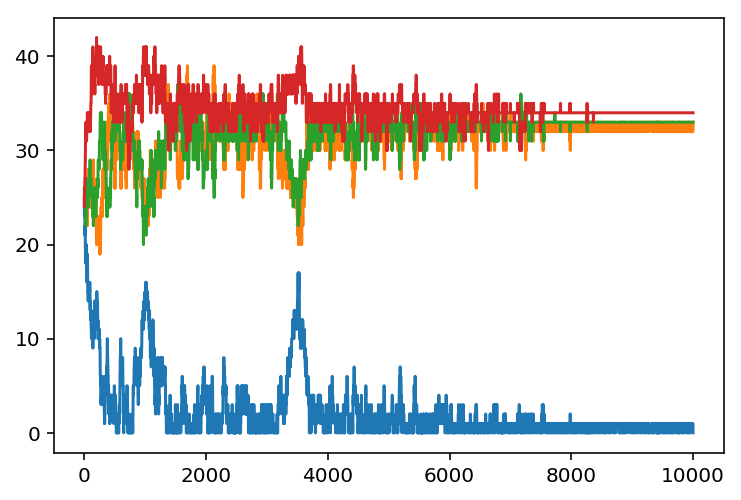

In [11]:
plt.plot(trace);

The objective function converges

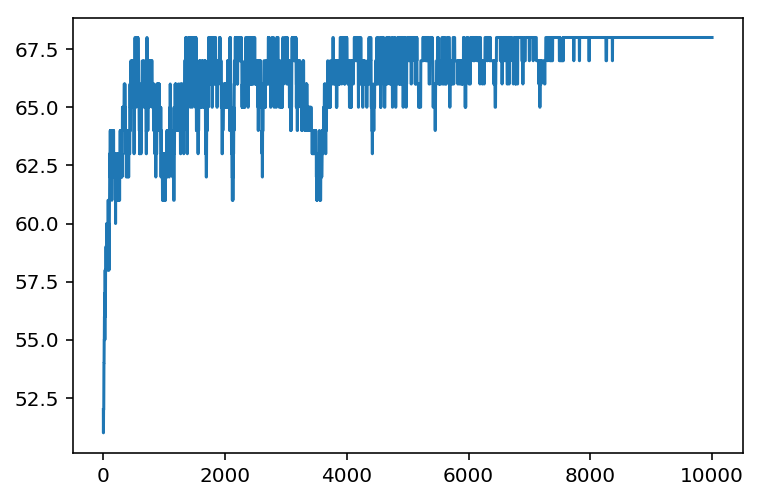

In [12]:
plt.plot([objective(tuple(s)) for s in trace]);

Ten thousand iterations is clearly overkill in this case, but hey, it runs fast.

Now for the actual problem...

In [13]:
s_opt, trace = sim_anneal([10]*10, obj, neighbor, temperature, 10000)

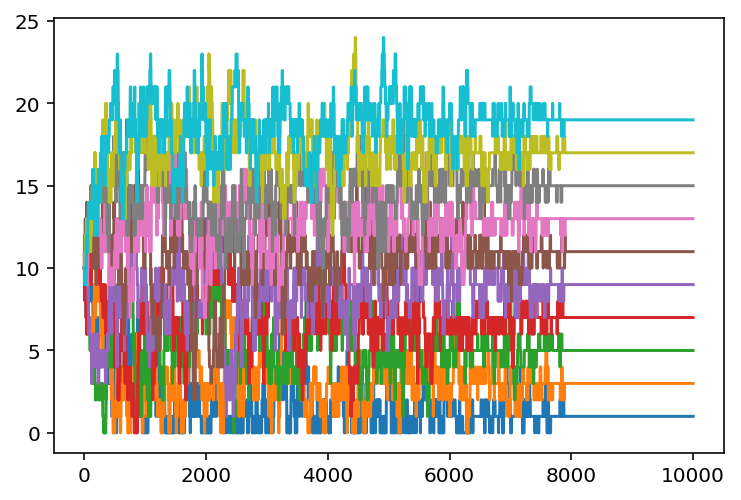

In [14]:
plt.plot(trace);

Here is a stackplot as an alternative

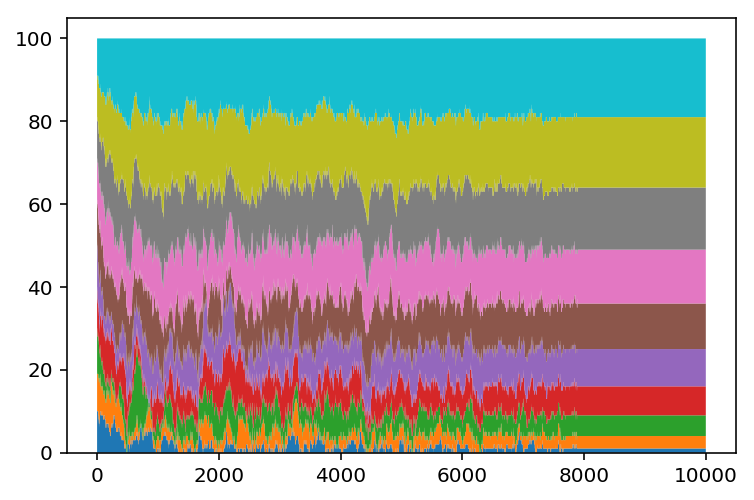

In [15]:
plt.stackplot(list(range(10000)), *zip(*trace));

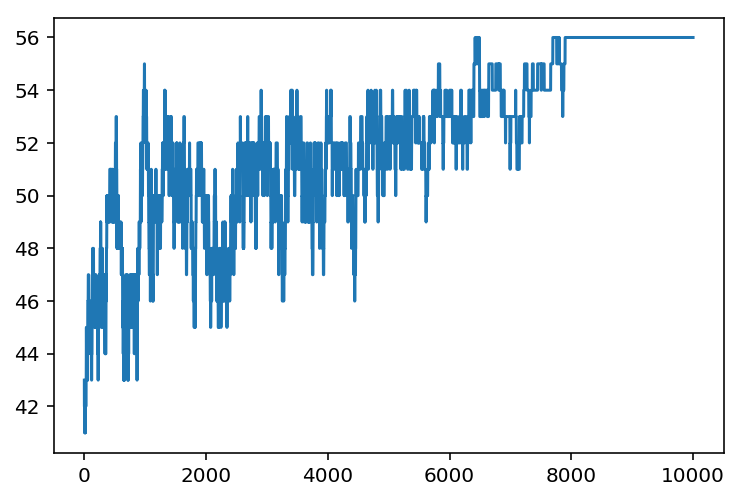

In [16]:
plt.plot([objective(tuple(s)) for s in trace]);

This time around we have a single solution. What is it then?

In [17]:
trace[-1]

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

This is kind of a remarkable result. The optimal assignment is an arithmetic progression! The number of troops neede to win in this case is

In [18]:
objective(tuple(trace[-1]))

56

Hence, the value of the spy is the same as 44 men.